# Bootstrap Resampling for Frontal Precip Analysis

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import matplotlib as mpl
import xesmf as xe
import nc_time_axis
import cftime 
import cartopy.crs as ccrs
import cartopy.feature as cfeature
from cartopy.util import add_cyclic_point
from scipy import stats

In [2]:
# Import dask
import dask

# Use dask jobqueue
from dask_jobqueue import PBSCluster

# Import a client
from dask.distributed import Client

# Setup your PBSCluster
cluster = PBSCluster(
    cores=1, # The number of cores you want
    memory='20GB', # Amount of memory
    processes=1, # How many processes
    queue='casper', # The type of queue to utilize (/glade/u/apps/dav/opt/usr/bin/execcasper)
    local_directory='/glade/scratch/kdagon/dask-local', # Use your dask-local directory
    resource_spec='select=1:ncpus=1:mem=20GB', # Specify resources
    project='P06010014', # Input your project ID here
    walltime='06:00:00', # Amount of wall time
    interface='ib0', # Interface to use
)

# Scale up -- how to determine this number?
# Here asking for 10 or 20 nodes (10 or 20 dask workers)
cluster.scale(20)

# Adaptive scaling option!
#cluster.adapt(minimum=1, maximum=100, wait_count=60)

# Change your url to the dask dashboard so you can see it
dask.config.set({'distributed.dashboard.link':'https://jupyterhub.hpc.ucar.edu/stable/user/{USER}/proxy/{port}/status'})

# Setup your client
client = Client(cluster)

/glade/work/kdagon/miniconda/envs/PEx/lib/python3.9/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 37198 instead
  warnings.warn(


In [3]:
client

Connection method: Cluster object,Cluster type: PBSCluster
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/37198/status,
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/37198/status,Workers: 0
Total threads: 0,Total memory: 0 B
Comm: tcp://10.12.206.51:42916,Workers: 0
Dashboard: https://jupyterhub.hpc.ucar.edu/stable/user/kdagon/proxy/37198/status,Total threads: 0
Started: Just now,Total memory: 0 B


## Read and process fronts given input file
All fronts and fronts by type

In [4]:
def process_fronts(path, file):
    fronts_ds = xr.open_dataset(path+file, chunks={'time':360})
    
    # convert longitudes to match CESM data (conservative regridding only)
    #fronts_ds_lons = fronts_ds.assign_coords(lon=(fronts_ds.lon % 360), keep_attrs=True)
    #fronts_ds_lons.lon.attrs = fronts_ds.lon.attrs
    #fronts = fronts_ds_lons.fronts
    
    fronts = fronts_ds.fronts
    #print(fronts.front_type.values)
    
    # subset for a 15-year climatology (if applicable)
    if fronts.shape[0] > 43800:
        fronts = fronts[:43800]
        
    # subset for CONUS
    fronts = fronts.sel(lat=slice(26,50), lon=slice(-125,-68))

    # all fronts
    #allfronts = fronts.argmax(dim='front')
    #anyfront = allfronts.where(allfronts < 4) # masking out no front areas
    
    # select seasonal values
    #anyfront_DJF = anyfront.sel(time=anyfront.time.dt.season=="DJF")
    #anyfront_MAM = anyfront.sel(time=anyfront.time.dt.season=="MAM")
    #anyfront_JJA = anyfront.sel(time=anyfront.time.dt.season=="JJA")
    #anyfront_SON = anyfront.sel(time=anyfront.time.dt.season=="SON")
    
    # cold fronts
    allcoldfronts = fronts.sel(front=0) # see fronts.front_type.values for indices
    anycoldfront = allcoldfronts.where(allcoldfronts == 1) # masking out no cold front areas
    anycoldfront_DJF = anycoldfront.sel(time=anycoldfront.time.dt.season=="DJF")
    anycoldfront_MAM = anycoldfront.sel(time=anycoldfront.time.dt.season=="MAM")
    anycoldfront_JJA = anycoldfront.sel(time=anycoldfront.time.dt.season=="JJA")
    anycoldfront_SON = anycoldfront.sel(time=anycoldfront.time.dt.season=="SON")
    
    # warm fronts
    allwarmfronts = fronts.sel(front=1)
    anywarmfront = allwarmfronts.where(allwarmfronts == 1)
    anywarmfront_DJF = anywarmfront.sel(time=anywarmfront.time.dt.season=="DJF")
    anywarmfront_MAM = anywarmfront.sel(time=anywarmfront.time.dt.season=="MAM")
    anywarmfront_JJA = anywarmfront.sel(time=anywarmfront.time.dt.season=="JJA")
    anywarmfront_SON = anywarmfront.sel(time=anywarmfront.time.dt.season=="SON")
    
    # stationary fronts
    allstatfronts = fronts.sel(front=2)
    anystatfront = allstatfronts.where(allstatfronts == 1)
    anystatfront_DJF = anystatfront.sel(time=anystatfront.time.dt.season=="DJF")
    anystatfront_MAM = anystatfront.sel(time=anystatfront.time.dt.season=="MAM")
    anystatfront_JJA = anystatfront.sel(time=anystatfront.time.dt.season=="JJA")
    anystatfront_SON = anystatfront.sel(time=anystatfront.time.dt.season=="SON")
    
    # occluded fronts
    alloccfronts = fronts.sel(front=3)
    anyoccfront = alloccfronts.where(alloccfronts == 1)
    anyoccfront_DJF = anyoccfront.sel(time=anyoccfront.time.dt.season=="DJF")
    anyoccfront_MAM = anyoccfront.sel(time=anyoccfront.time.dt.season=="MAM")
    anyoccfront_JJA = anyoccfront.sel(time=anyoccfront.time.dt.season=="JJA")
    anyoccfront_SON = anyoccfront.sel(time=anyoccfront.time.dt.season=="SON")
    
    #anyfront_types = xr.concat([anycoldfront, anywarmfront, anystatfront, anyoccfront], dim='front_type')
    #return(anyfront, anyfront_types)

    # return all fronts by season
    #return(anyfront_DJF, anyfront_MAM, anyfront_JJA, anyfront_SON)

    # return front types by season
    return(anycoldfront_DJF, anycoldfront_MAM, anycoldfront_JJA, anycoldfront_SON,
           anywarmfront_DJF, anywarmfront_MAM, anywarmfront_JJA, anywarmfront_SON,
           anystatfront_DJF, anystatfront_MAM, anystatfront_JJA, anystatfront_SON,
           anyoccfront_DJF, anyoccfront_MAM, anyoccfront_JJA, anyoccfront_SON)

In [7]:
cesm_fronts_filepath = "/glade/work/kdagon/FrontDetector/CESMOutputs/"
fronts_file = "cesm_fronts_2000-2015_MaskedNetCDF_customgrid.nc"
#fronts_DJF, fronts_MAM, fronts_JJA, fronts_SON = process_fronts(cesm_fronts_filepath, fronts_file)
cfronts_DJF, cfronts_MAM, cfronts_JJA, cfronts_SON, wfronts_DJF, wfronts_MAM, wfronts_JJA, wfronts_SON, sfronts_DJF, sfronts_MAM, sfronts_JJA, sfronts_SON, ofronts_DJF, ofronts_MAM, ofronts_JJA, ofronts_SON = process_fronts(cesm_fronts_filepath, fronts_file)

In [9]:
fronts_file_rcp = "cesm_fronts_2086-2100_MaskedNetCDF_customgrid.nc"
#fronts_DJF_rcp, fronts_MAM_rcp, fronts_JJA_rcp, fronts_SON_rcp = process_fronts(cesm_fronts_filepath, fronts_file_rcp)
cfronts_DJF_rcp, cfronts_MAM_rcp, cfronts_JJA_rcp, cfronts_SON_rcp, wfronts_DJF_rcp, wfronts_MAM_rcp, wfronts_JJA_rcp, wfronts_SON_rcp, sfronts_DJF_rcp, sfronts_MAM_rcp, sfronts_JJA_rcp, sfronts_SON_rcp, ofronts_DJF_rcp, ofronts_MAM_rcp, ofronts_JJA_rcp, ofronts_SON_rcp = process_fronts(cesm_fronts_filepath, fronts_file_rcp)

### Read landfrac to subset land points (optional)

In [8]:
postprocessing_filepath = '/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/'
landfrac_file = 'landfrac_1deg_bil.nc'

In [9]:
landfrac = xr.open_dataarray(postprocessing_filepath+landfrac_file)

## Read and process precipitation given input file

In [10]:
#def process_PRECT(path, file, landfrac):
def process_PRECT(path, file):
    PRECT_1deg = xr.open_dataarray(path+file, chunks={'time':600, 'lat':10, 'lon':20})
    
    # subset for a 15-year climatology (if applicable)
    if PRECT_1deg.shape[0] > 43800:
        PRECT_1deg = PRECT_1deg[:43800]
    
    # subset for land only (optional; comment out to use whole domain)
    #PRECT_1deg = PRECT_1deg.where(landfrac > 0)
    
    # subset for CONUS only
    PRECT_CONUS = PRECT_1deg.sel(lat=slice(26,50), lon=slice(-125,-68))
    
    # select seasonal values
    PRECT_DJF = PRECT_CONUS.sel(time=PRECT_CONUS.time.dt.season=="DJF")
    PRECT_MAM = PRECT_CONUS.sel(time=PRECT_CONUS.time.dt.season=="MAM")
    PRECT_JJA = PRECT_CONUS.sel(time=PRECT_CONUS.time.dt.season=="JJA")
    PRECT_SON = PRECT_CONUS.sel(time=PRECT_CONUS.time.dt.season=="SON")
    
    return(PRECT_DJF, PRECT_MAM, PRECT_JJA, PRECT_SON)

In [11]:
postprocessing_filepath = '/glade/campaign/cgd/ccr/kdagon/dlfront/postprocessing/'
PRECT_file = 'PRECT_3hravg_NA_hist_rcp26_1deg_bil.nc' # bilinear interpolation, units are m/s
#PRECT_file = 'PRECT_3hravg_NA_hist_rcp26_1deg_cons.nc' # conservative regridding
PRECT_DJF, PRECT_MAM, PRECT_JJA, PRECT_SON = process_PRECT(postprocessing_filepath, PRECT_file)

PRECT_file_rcp = 'PRECT_3hravg_NA_rcp85_1deg_bil.nc'
PRECT_DJF_rcp, PRECT_MAM_rcp, PRECT_JJA_rcp, PRECT_SON_rcp = process_PRECT(postprocessing_filepath, PRECT_file_rcp)

## Bootstrap resampling

#### Create components for bootstrapping

In [14]:
def process_timeseries(f1, f2, P1, P2):

    # frontal precipitation for each simulation
    P1_f1 = P1.where(f1.notnull())
    P2_f2 = P2.where(f2.notnull())
    # concatenate the timeseries
    P_f_concat = xr.concat([P1_f1, P2_f2], dim='time')
    
    # precipitation for each simulation
    P_concat = xr.concat([P1, P2], dim='time')
    
    return(P_f_concat, P_concat)

In [12]:
# all fronts
#PRECT_front_DJF_concat, PRECT_DJF_concat = process_timeseries(fronts_DJF, fronts_DJF_rcp, PRECT_DJF, PRECT_DJF_rcp)
#PRECT_front_MAM_concat, PRECT_MAM_concat = process_timeseries(fronts_MAM, fronts_MAM_rcp, PRECT_MAM, PRECT_MAM_rcp)
#PRECT_front_JJA_concat, PRECT_JJA_concat = process_timeseries(fronts_JJA, fronts_JJA_rcp, PRECT_JJA, PRECT_JJA_rcp)
#PRECT_front_SON_concat, PRECT_SON_concat = process_timeseries(fronts_SON, fronts_SON_rcp, PRECT_SON, PRECT_SON_rcp)

In [15]:
# cold fronts
PRECT_cfront_DJF_concat, PRECT_DJF_concat = process_timeseries(cfronts_DJF, cfronts_DJF_rcp, PRECT_DJF, PRECT_DJF_rcp)
PRECT_cfront_MAM_concat, PRECT_MAM_concat = process_timeseries(cfronts_MAM, cfronts_MAM_rcp, PRECT_MAM, PRECT_MAM_rcp)
PRECT_cfront_JJA_concat, PRECT_JJA_concat = process_timeseries(cfronts_JJA, cfronts_JJA_rcp, PRECT_JJA, PRECT_JJA_rcp)
PRECT_cfront_SON_concat, PRECT_SON_concat = process_timeseries(cfronts_SON, cfronts_SON_rcp, PRECT_SON, PRECT_SON_rcp)

In [47]:
# warm fronts
PRECT_wfront_DJF_concat, PRECT_DJF_concat = process_timeseries(wfronts_DJF, wfronts_DJF_rcp, PRECT_DJF, PRECT_DJF_rcp)
PRECT_wfront_MAM_concat, PRECT_MAM_concat = process_timeseries(wfronts_MAM, wfronts_MAM_rcp, PRECT_MAM, PRECT_MAM_rcp)
PRECT_wfront_JJA_concat, PRECT_JJA_concat = process_timeseries(wfronts_JJA, wfronts_JJA_rcp, PRECT_JJA, PRECT_JJA_rcp)
PRECT_wfront_SON_concat, PRECT_SON_concat = process_timeseries(wfronts_SON, wfronts_SON_rcp, PRECT_SON, PRECT_SON_rcp)

In [73]:
# stat fronts
PRECT_sfront_DJF_concat, PRECT_DJF_concat = process_timeseries(sfronts_DJF, sfronts_DJF_rcp, PRECT_DJF, PRECT_DJF_rcp)
PRECT_sfront_MAM_concat, PRECT_MAM_concat = process_timeseries(sfronts_MAM, sfronts_MAM_rcp, PRECT_MAM, PRECT_MAM_rcp)
PRECT_sfront_JJA_concat, PRECT_JJA_concat = process_timeseries(sfronts_JJA, sfronts_JJA_rcp, PRECT_JJA, PRECT_JJA_rcp)
PRECT_sfront_SON_concat, PRECT_SON_concat = process_timeseries(sfronts_SON, sfronts_SON_rcp, PRECT_SON, PRECT_SON_rcp)

In [100]:
# occ fronts
PRECT_ofront_DJF_concat, PRECT_DJF_concat = process_timeseries(ofronts_DJF, ofronts_DJF_rcp, PRECT_DJF, PRECT_DJF_rcp)
PRECT_ofront_MAM_concat, PRECT_MAM_concat = process_timeseries(ofronts_MAM, ofronts_MAM_rcp, PRECT_MAM, PRECT_MAM_rcp)
PRECT_ofront_JJA_concat, PRECT_JJA_concat = process_timeseries(ofronts_JJA, ofronts_JJA_rcp, PRECT_JJA, PRECT_JJA_rcp)
PRECT_ofront_SON_concat, PRECT_SON_concat = process_timeseries(ofronts_SON, ofronts_SON_rcp, PRECT_SON, PRECT_SON_rcp)

In [30]:
# persist values for computation - still slow
#PRECT_front_concat = PRECT_front_concat.persist()
#PRECT_concat = PRECT_concat.persist()

In [16]:
%%time
# compute values to load into memory

# all fronts
#PRECT_front_DJF_concat_compute = PRECT_front_DJF_concat.compute()

# cold fronts
PRECT_cfront_DJF_concat_compute = PRECT_cfront_DJF_concat.compute()

CPU times: user 6.09 s, sys: 538 ms, total: 6.62 s
Wall time: 9.77 s


In [66]:
PRECT_front_DJF_concat_compute.shape

(21600, 25, 58)

In [ ]:
# convert to numpy array (optional)
#PRECT_front_DJF_concat_forboot = PRECT_front_DJF_concat_compute.values

In [ ]:
# check the shape
#PRECT_front_DJF_concat_forboot.shape

In [17]:
%%time
PRECT_DJF_concat_compute = PRECT_DJF_concat.compute()

CPU times: user 2.33 s, sys: 431 ms, total: 2.76 s
Wall time: 4.67 s


In [65]:
PRECT_DJF_concat_compute.shape

(21600, 25, 58)

In [18]:
%%time
# compute the rest of the seasons

# all fronts
#PRECT_front_MAM_concat_compute = PRECT_front_MAM_concat.compute()
#PRECT_front_JJA_concat_compute = PRECT_front_JJA_concat.compute()
#PRECT_front_SON_concat_compute = PRECT_front_SON_concat.compute()

# cold fronts
PRECT_cfront_MAM_concat_compute = PRECT_cfront_MAM_concat.compute()
PRECT_cfront_JJA_concat_compute = PRECT_cfront_JJA_concat.compute()
PRECT_cfront_SON_concat_compute = PRECT_cfront_SON_concat.compute()

# PRECT
PRECT_MAM_concat_compute = PRECT_MAM_concat.compute()
PRECT_JJA_concat_compute = PRECT_JJA_concat.compute()
PRECT_SON_concat_compute = PRECT_SON_concat.compute()

CPU times: user 29 s, sys: 2.66 s, total: 31.7 s
Wall time: 49.5 s


In [48]:
# warm fronts
PRECT_wfront_DJF_concat_compute = PRECT_wfront_DJF_concat.compute()
PRECT_wfront_MAM_concat_compute = PRECT_wfront_MAM_concat.compute()
PRECT_wfront_JJA_concat_compute = PRECT_wfront_JJA_concat.compute()
PRECT_wfront_SON_concat_compute = PRECT_wfront_SON_concat.compute()

In [74]:
# stat fronts
PRECT_sfront_DJF_concat_compute = PRECT_sfront_DJF_concat.compute()
PRECT_sfront_MAM_concat_compute = PRECT_sfront_MAM_concat.compute()
PRECT_sfront_JJA_concat_compute = PRECT_sfront_JJA_concat.compute()
PRECT_sfront_SON_concat_compute = PRECT_sfront_SON_concat.compute()

In [101]:
# occ fronts
PRECT_ofront_DJF_concat_compute = PRECT_ofront_DJF_concat.compute()
PRECT_ofront_MAM_concat_compute = PRECT_ofront_MAM_concat.compute()
PRECT_ofront_JJA_concat_compute = PRECT_ofront_JJA_concat.compute()
PRECT_ofront_SON_concat_compute = PRECT_ofront_SON_concat.compute()

In [19]:
# calculate number of timesteps for each season
totalsize_DJF = PRECT_DJF_concat.time.size
totalsize_MAM = PRECT_MAM_concat.time.size
totalsize_JJA = PRECT_JJA_concat.time.size
totalsize_SON = PRECT_SON_concat.time.size

#### DJF

In [102]:
%%time
# NOTE: load the concatenated arrays into memory first

nsamps = 1000

# initialize a difference array
#diffs_DJF = np.zeros((PRECT_DJF_concat_compute.shape)) # np version
diffs_DJF = xr.zeros_like(PRECT_DJF_concat_compute[:nsamps,:,:]).reset_index('time', drop='True').rename({'time': 'sample'}) # xr version

for ind in range(nsamps):
    
    # sample 1 - set the random seed for reproducibility
    np.random.seed(ind+1)
    # create the random indices based on totalsize
    rand_index = np.random.choice(totalsize_DJF, size=int(totalsize_DJF/2), replace=True)
    
    # randomly sample the concatenated frontal precip across hist/rcp
    # options for working in numpy or xarray space
    # all fronts
    #boot_1 = np.nansum(PRECT_front_DJF_concat_compute[rand_index,...], axis=0)
    #boot_1 = PRECT_front_DJF_concat_compute.isel(time=rand_index).sum(dim='time')
    # cold fronts
    #boot_1 = PRECT_cfront_DJF_concat_compute.isel(time=rand_index).sum(dim='time')
    # warm fronts
    #boot_1 = PRECT_wfront_DJF_concat_compute.isel(time=rand_index).sum(dim='time')
    # stat fronts
    #boot_1 = PRECT_sfront_DJF_concat_compute.isel(time=rand_index).sum(dim='time')
    # occ fronts
    boot_1 = PRECT_ofront_DJF_concat_compute.isel(time=rand_index).sum(dim='time')
    
    # randomly sample the concatenated precip across hist/rcp
    #boot_2 = np.nansum(PRECT_DJF_concat_compute[rand_index,...], axis=0)
    boot_2 = PRECT_DJF_concat_compute.isel(time=rand_index).sum(dim='time')
    # compute the fraction of frontal precip
    frac = boot_1/boot_2
    
    # sample 2 - different random seed
    np.random.seed(ind+10)
    rand_index = np.random.choice(totalsize_DJF, size=int(totalsize_DJF/2), replace=True)
    #boot_1 = np.nansum(PRECT_front_DJF_concat_compute[rand_index,...], axis=0)
    #boot_1 = PRECT_front_DJF_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_cfront_DJF_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_wfront_DJF_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_sfront_DJF_concat_compute.isel(time=rand_index).sum(dim='time')
    boot_1 = PRECT_ofront_DJF_concat_compute.isel(time=rand_index).sum(dim='time')
    
    #boot_2 = np.nansum(PRECT_DJF_concat_compute[rand_index,...], axis=0)
    boot_2 = PRECT_DJF_concat_compute.isel(time=rand_index).sum(dim='time')
    
    frac2 = boot_1/boot_2
    
    # final bootstrap sample is the difference between samples
    diffs_DJF[ind,...] = 100*(frac - frac2) # can save these out as individual netcdf files (spatial maps) for each sample if memory is an issue
    
    # then save and load back in diff maps, calculate quantiles (2 tailed), use those as bounds for hatching

    # test first iteration of loop
    #break

CPU times: user 6min 23s, sys: 7min 32s, total: 13min 56s
Wall time: 19min 46s


In [ ]:
diffs_DJF.shape

(1000, 25, 58)

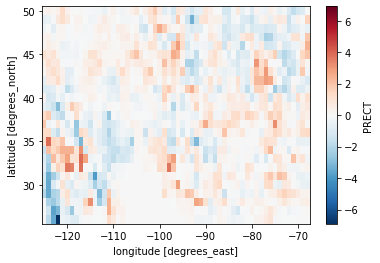

In [ ]:
# distribution of values at first sample across space
diffs_DJF.isel(sample=0).plot()

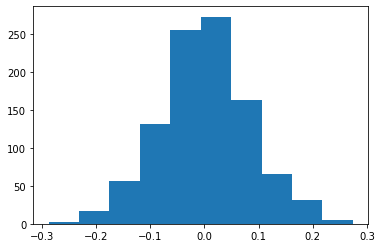

In [ ]:
# distribution of values at first spatial point
plt.hist(diffs_DJF[:,0,0]);

In [106]:
lev_1 = 0.025
lev_2 = 0.975

DJF_quantiles = diffs_DJF.quantile([lev_1,lev_2], dim='sample')

In [107]:
DJF_quantiles

<xarray.DataArray 'PRECT' (quantile: 2, lat: 25, lon: 58)>
array([[[-0.16864619, -1.86844226, -3.2801722 , ..., -0.03102896,
         -0.02757453, -0.01939991],
        [-0.12481008, -1.38697674, -3.50107399, ..., -0.24516729,
         -0.17020362, -0.19545741],
        [-0.19933268, -2.29566116, -4.30191681, ..., -0.6283272 ,
         -0.75990033, -0.95961649],
        ...,
        [-1.49116915, -1.3333428 , -1.38147712, ..., -2.04510167,
         -2.17735057, -2.59311297],
        [-1.61200784, -1.45271689, -1.17002926, ..., -2.17722886,
         -2.38833541, -2.54166659],
        [-1.76986129, -1.31487764, -1.11849933, ..., -1.97301194,
         -2.27352646, -2.40995004]],

       [[ 0.17415302,  1.80225669,  3.25064601, ...,  0.03153391,
          0.02759805,  0.0193413 ],
        [ 0.12219169,  1.31265929,  3.30903978, ...,  0.23576643,
          0.17063564,  0.19243786],
        [ 0.18815459,  2.22575854,  4.04478517, ...,  0.60630994,
          0.76747154,  0.95492508],
        ...,
        [ 1.39283844,  1.307097  ,  1.40075108, ...,  1.99301656,
          2.1380701 ,  2.59049321],
        [ 1.66344101,  1.45691023,  1.06780526, ...,  2.15963904,
          2.33163339,  2.34482   ],
        [ 1.75918338,  1.20280946,  1.13196578, ...,  1.96922752,
          2.10414682,  2.44475964]]])
Coordinates:
  * lon       (lon) float64 -125.0 -124.0 -123.0 -122.0 ... -70.0 -69.0 -68.0
  * lat       (lat) float64 26.0 27.0 28.0 29.0 30.0 ... 47.0 48.0 49.0 50.0
  * quantile  (quantile) float64 0.025 0.975

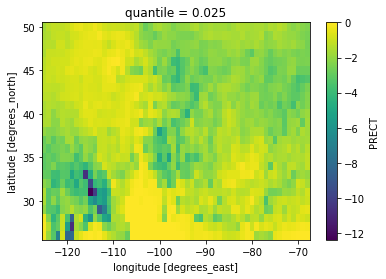

In [108]:
DJF_quantiles.sel(quantile=lev_1).plot()

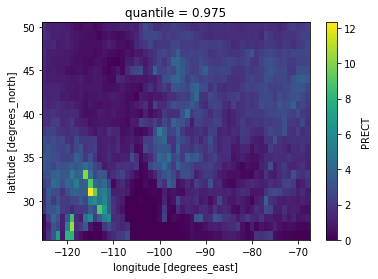

In [109]:
DJF_quantiles.sel(quantile=lev_2).plot()

#### MAM

In [110]:
%%time
# NOTE: load the concatenated arrays into memory first

nsamps = 1000

# initialize a difference array
diffs_MAM = xr.zeros_like(PRECT_MAM_concat_compute[:nsamps,:,:]).reset_index('time', drop='True').rename({'time': 'sample'})

for ind in range(nsamps):
    
    # sample 1 - set the random seed for reproducibility
    np.random.seed(ind+1)
    # create the random indices based on totalsize
    rand_index = np.random.choice(totalsize_MAM, size=int(totalsize_MAM/2), replace=True)
    
    # randomly sample the concatenated frontal precip across hist/rcp
    #boot_1 = PRECT_front_MAM_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_cfront_MAM_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_wfront_MAM_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_sfront_MAM_concat_compute.isel(time=rand_index).sum(dim='time')
    boot_1 = PRECT_ofront_MAM_concat_compute.isel(time=rand_index).sum(dim='time')
    
    # randomly sample the concatenated precip across hist/rcp
    boot_2 = PRECT_MAM_concat_compute.isel(time=rand_index).sum(dim='time')
    frac = boot_1/boot_2
    
    # sample 2 - different random seed
    np.random.seed(ind+10)
    rand_index = np.random.choice(totalsize_MAM, size=int(totalsize_MAM/2), replace=True)
    #boot_1 = PRECT_front_MAM_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_cfront_MAM_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_wfront_MAM_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_sfront_MAM_concat_compute.isel(time=rand_index).sum(dim='time')
    boot_1 = PRECT_ofront_MAM_concat_compute.isel(time=rand_index).sum(dim='time')
    boot_2 = PRECT_MAM_concat_compute.isel(time=rand_index).sum(dim='time')
    frac2 = boot_1/boot_2
    
    # final bootstrap sample is the difference between samples
    diffs_MAM[ind,...] = 100*(frac - frac2) 
    
    # then save and load back in diff maps, calculate quantiles (2 tailed), use those as bounds for hatching

    # test first iteration of loop
    #break

CPU times: user 5min 58s, sys: 7min 42s, total: 13min 40s
Wall time: 17min 21s


In [111]:
MAM_quantiles = diffs_MAM.quantile([lev_1,lev_2], dim='sample')

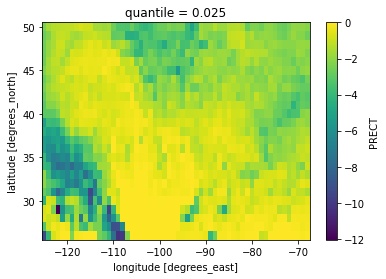

In [112]:
MAM_quantiles.sel(quantile=lev_1).plot()

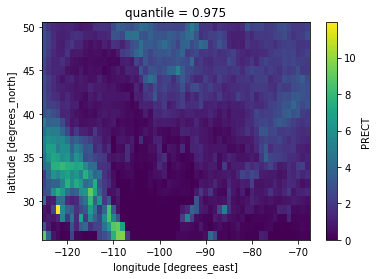

In [113]:
MAM_quantiles.sel(quantile=lev_2).plot()

#### JJA

In [114]:
%%time
# NOTE: load the concatenated arrays into memory first

nsamps = 1000

# initialize a difference array
diffs_JJA = xr.zeros_like(PRECT_JJA_concat_compute[:nsamps,:,:]).reset_index('time', drop='True').rename({'time': 'sample'})

for ind in range(nsamps):
    
    # sample 1 - set the random seed for reproducibility
    np.random.seed(ind+1)
    # create the random indices based on totalsize
    rand_index = np.random.choice(totalsize_JJA, size=int(totalsize_JJA/2), replace=True)
    
    # randomly sample the concatenated frontal precip across hist/rcp
    #boot_1 = PRECT_front_JJA_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_cfront_JJA_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_wfront_JJA_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_sfront_JJA_concat_compute.isel(time=rand_index).sum(dim='time')
    boot_1 = PRECT_ofront_JJA_concat_compute.isel(time=rand_index).sum(dim='time')
    
    # randomly sample the concatenated precip across hist/rcp
    boot_2 = PRECT_JJA_concat_compute.isel(time=rand_index).sum(dim='time')
    frac = boot_1/boot_2
    
    # sample 2 - different random seed
    np.random.seed(ind+10)
    rand_index = np.random.choice(totalsize_JJA, size=int(totalsize_JJA/2), replace=True)
    #boot_1 = PRECT_front_JJA_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_cfront_JJA_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_wfront_JJA_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_sfront_JJA_concat_compute.isel(time=rand_index).sum(dim='time')
    boot_1 = PRECT_ofront_JJA_concat_compute.isel(time=rand_index).sum(dim='time')
    boot_2 = PRECT_JJA_concat_compute.isel(time=rand_index).sum(dim='time')
    frac2 = boot_1/boot_2
    
    # final bootstrap sample is the difference between samples
    diffs_JJA[ind,...] = 100*(frac - frac2) 
    
    # then save and load back in diff maps, calculate quantiles (2 tailed), use those as bounds for hatching

    # test first iteration of loop
    #break

CPU times: user 5min 54s, sys: 7min 54s, total: 13min 48s
Wall time: 17min 3s


In [115]:
JJA_quantiles = diffs_JJA.quantile([lev_1,lev_2], dim='sample')

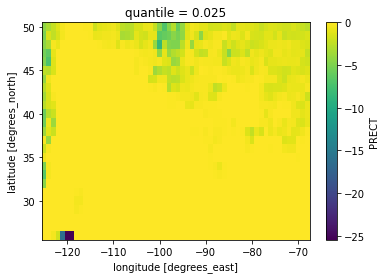

In [116]:
JJA_quantiles.sel(quantile=lev_1).plot()

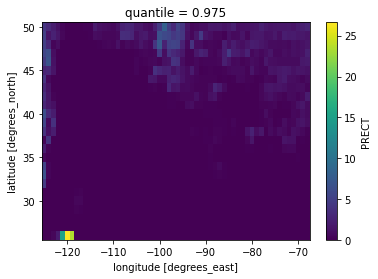

In [117]:
JJA_quantiles.sel(quantile=lev_2).plot()

#### SON

In [118]:
%%time
# NOTE: load the concatenated arrays into memory first

nsamps = 1000

# initialize a difference array
diffs_SON = xr.zeros_like(PRECT_SON_concat_compute[:nsamps,:,:]).reset_index('time', drop='True').rename({'time': 'sample'})

for ind in range(nsamps):
    
    # sample 1 - set the random seed for reproducibility
    np.random.seed(ind+1)
    # create the random indices based on totalsize
    rand_index = np.random.choice(totalsize_SON, size=int(totalsize_SON/2), replace=True)
    
    # randomly sample the concatenated frontal precip across hist/rcp
    #boot_1 = PRECT_front_SON_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_cfront_SON_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_wfront_SON_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_sfront_SON_concat_compute.isel(time=rand_index).sum(dim='time')
    boot_1 = PRECT_ofront_SON_concat_compute.isel(time=rand_index).sum(dim='time')
    
    # randomly sample the concatenated precip across hist/rcp
    boot_2 = PRECT_SON_concat_compute.isel(time=rand_index).sum(dim='time')
    frac = boot_1/boot_2
    
    # sample 2 - different random seed
    np.random.seed(ind+10)
    rand_index = np.random.choice(totalsize_SON, size=int(totalsize_SON/2), replace=True)
    #boot_1 = PRECT_front_SON_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_cfront_SON_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_wfront_SON_concat_compute.isel(time=rand_index).sum(dim='time')
    #boot_1 = PRECT_sfront_SON_concat_compute.isel(time=rand_index).sum(dim='time')
    boot_1 = PRECT_ofront_SON_concat_compute.isel(time=rand_index).sum(dim='time')
    boot_2 = PRECT_SON_concat_compute.isel(time=rand_index).sum(dim='time')
    frac2 = boot_1/boot_2
    
    # final bootstrap sample is the difference between samples
    diffs_SON[ind,...] = 100*(frac - frac2) 
    
    # then save and load back in diff maps, calculate quantiles (2 tailed), use those as bounds for hatching

    # test first iteration of loop
    #break

CPU times: user 5min 52s, sys: 7min 48s, total: 13min 40s
Wall time: 17min


In [119]:
SON_quantiles = diffs_SON.quantile([lev_1,lev_2], dim='sample')

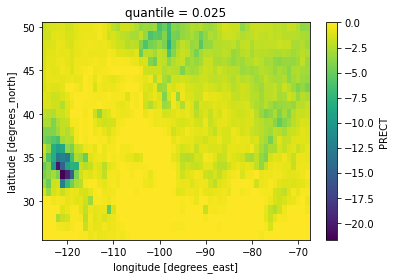

In [120]:
SON_quantiles.sel(quantile=lev_1).plot()

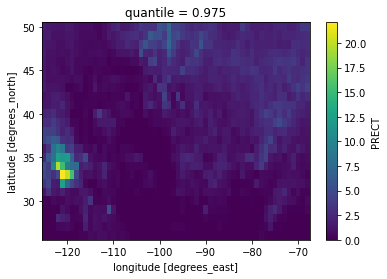

In [121]:
SON_quantiles.sel(quantile=lev_2).plot()

## Save out quantile values for plotting in other notebooks

#### Concatenate across season for easier plotting

In [122]:
seasonal_quantiles = xr.concat([DJF_quantiles, MAM_quantiles, JJA_quantiles, SON_quantiles], dim='season')
seasonal_quantiles

<xarray.DataArray 'PRECT' (season: 4, quantile: 2, lat: 25, lon: 58)>
array([[[[-0.16864619, -1.86844226, -3.2801722 , ..., -0.03102896,
          -0.02757453, -0.01939991],
         [-0.12481008, -1.38697674, -3.50107399, ..., -0.24516729,
          -0.17020362, -0.19545741],
         [-0.19933268, -2.29566116, -4.30191681, ..., -0.6283272 ,
          -0.75990033, -0.95961649],
         ...,
         [-1.49116915, -1.3333428 , -1.38147712, ..., -2.04510167,
          -2.17735057, -2.59311297],
         [-1.61200784, -1.45271689, -1.17002926, ..., -2.17722886,
          -2.38833541, -2.54166659],
         [-1.76986129, -1.31487764, -1.11849933, ..., -1.97301194,
          -2.27352646, -2.40995004]],

        [[ 0.17415302,  1.80225669,  3.25064601, ...,  0.03153391,
           0.02759805,  0.0193413 ],
         [ 0.12219169,  1.31265929,  3.30903978, ...,  0.23576643,
           0.17063564,  0.19243786],
         [ 0.18815459,  2.22575854,  4.04478517, ...,  0.60630994,
           0.76747154,  0.95492508],
...
         [-1.43498671, -1.25779954, -1.12763894, ..., -2.80967013,
          -2.52879012, -3.08185901],
         [-1.62869017, -1.56556174, -0.99003852, ..., -2.40799588,
          -2.77227734, -2.90770105],
         [-1.93945957, -1.41700593, -1.25058817, ..., -2.48656165,
          -3.64266063, -3.53676127]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.01392648,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.03779271, ...,  0.01140141,
           0.        ,  0.        ],
         ...,
         [ 1.41852143,  1.25118576,  1.18055524, ...,  2.86101279,
           2.66526837,  2.89275362],
         [ 1.52888999,  1.59257078,  0.97070698, ...,  2.5495968 ,
           2.62854544,  2.86102031],
         [ 1.78177287,  1.39783993,  1.23710069, ...,  2.55954804,
           3.47716756,  3.50698983]]]])
Coordinates:
  * lon       (lon) float64 -125.0 -124.0 -123.0 -122.0 ... -70.0 -69.0 -68.0
  * lat       (lat) float64 26.0 27.0 28.0 29.0 30.0 ... 47.0 48.0 49.0 50.0
  * quantile  (quantile) float64 0.025 0.975
Dimensions without coordinates: season

In [123]:
seasonal_quantiles.coords["season"] = ['DJF','MAM','JJA','SON']
seasonal_quantiles

<xarray.DataArray 'PRECT' (season: 4, quantile: 2, lat: 25, lon: 58)>
array([[[[-0.16864619, -1.86844226, -3.2801722 , ..., -0.03102896,
          -0.02757453, -0.01939991],
         [-0.12481008, -1.38697674, -3.50107399, ..., -0.24516729,
          -0.17020362, -0.19545741],
         [-0.19933268, -2.29566116, -4.30191681, ..., -0.6283272 ,
          -0.75990033, -0.95961649],
         ...,
         [-1.49116915, -1.3333428 , -1.38147712, ..., -2.04510167,
          -2.17735057, -2.59311297],
         [-1.61200784, -1.45271689, -1.17002926, ..., -2.17722886,
          -2.38833541, -2.54166659],
         [-1.76986129, -1.31487764, -1.11849933, ..., -1.97301194,
          -2.27352646, -2.40995004]],

        [[ 0.17415302,  1.80225669,  3.25064601, ...,  0.03153391,
           0.02759805,  0.0193413 ],
         [ 0.12219169,  1.31265929,  3.30903978, ...,  0.23576643,
           0.17063564,  0.19243786],
         [ 0.18815459,  2.22575854,  4.04478517, ...,  0.60630994,
           0.76747154,  0.95492508],
...
         [-1.43498671, -1.25779954, -1.12763894, ..., -2.80967013,
          -2.52879012, -3.08185901],
         [-1.62869017, -1.56556174, -0.99003852, ..., -2.40799588,
          -2.77227734, -2.90770105],
         [-1.93945957, -1.41700593, -1.25058817, ..., -2.48656165,
          -3.64266063, -3.53676127]],

        [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.        , ...,  0.01392648,
           0.        ,  0.        ],
         [ 0.        ,  0.        ,  0.03779271, ...,  0.01140141,
           0.        ,  0.        ],
         ...,
         [ 1.41852143,  1.25118576,  1.18055524, ...,  2.86101279,
           2.66526837,  2.89275362],
         [ 1.52888999,  1.59257078,  0.97070698, ...,  2.5495968 ,
           2.62854544,  2.86102031],
         [ 1.78177287,  1.39783993,  1.23710069, ...,  2.55954804,
           3.47716756,  3.50698983]]]])
Coordinates:
  * lon       (lon) float64 -125.0 -124.0 -123.0 -122.0 ... -70.0 -69.0 -68.0
  * lat       (lat) float64 26.0 27.0 28.0 29.0 30.0 ... 47.0 48.0 49.0 50.0
  * quantile  (quantile) float64 0.025 0.975
  * season    (season) <U3 'DJF' 'MAM' 'JJA' 'SON'

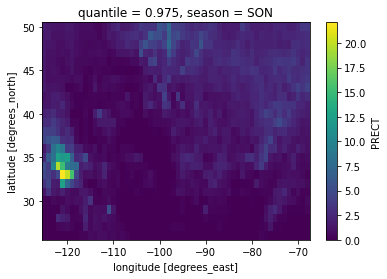

In [124]:
seasonal_quantiles.sel(season='SON',quantile=0.975).plot()

In [117]:
#seasonal_quantiles.to_netcdf(postprocessing_filepath+'PRECT_frontfrac_boot_diffs_byseason.nc', mode='w', format='NETCDF4')

In [46]:
#seasonal_quantiles.to_netcdf(postprocessing_filepath+'PRECT_frontfrac_cold_boot_diffs_byseason.nc', mode='w', format='NETCDF4')

In [72]:
#seasonal_quantiles.to_netcdf(postprocessing_filepath+'PRECT_frontfrac_warm_boot_diffs_byseason.nc', mode='w', format='NETCDF4')

In [99]:
#seasonal_quantiles.to_netcdf(postprocessing_filepath+'PRECT_frontfrac_stat_boot_diffs_byseason.nc', mode='w', format='NETCDF4')

In [125]:
seasonal_quantiles.to_netcdf(postprocessing_filepath+'PRECT_frontfrac_occ_boot_diffs_byseason.nc', mode='w', format='NETCDF4')

In [99]:
#DJF_quantiles.to_netcdf(postprocessing_filepath+'PRECT_frontfrac_boot_diffs_DJF.nc', mode='w', format='NETCDF4')

In [ ]:
#MAM_quantiles.to_netcdf(postprocessing_filepath+'PRECT_frontfrac_boot_diffs_MAM.nc', mode='w', format='NETCDF4')

In [ ]:
#JJA_quantiles.to_netcdf(postprocessing_filepath+'PRECT_frontfrac_boot_diffs_JJA.nc', mode='w', format='NETCDF4')

In [ ]:
#SON_quantiles.to_netcdf(postprocessing_filepath+'PRECT_frontfrac_boot_diffs_SON.nc', mode='w', format='NETCDF4')

#### playing around with the `boostrap` function from scipy

In [ ]:
from scipy.stats import bootstrap

In [ ]:
from scipy.stats import norm
sample1 = norm.rvs(scale=1, size=100)
sample2 = norm.rvs(scale=2, size=100)
data = (sample1, sample2)
data[0].shape

In [ ]:
# example of how to apply this function with given data and function
res = bootstrap(data, np.mean, method='percentile', confidence_level=0.95, paired=True, vectorized=False)
res